In [1]:
import torch

# Numpy for matrices
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx

/home/agherasie/anaconda3/envs/discover/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch_geometric.datasets import WikiCS

# Import dataset from PyTorch Geometric
dataset = WikiCS('./')

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

WikiCS()
------------
Number of graphs: 1
Number of features: 300
Number of classes: 10


/home/agherasie/anaconda3/envs/discover/lib/python3.9/site-packages/torch_geometric/datasets/wikics.py:38: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behaviour.
  warnings.warn(


In [3]:
print(f'Graph: {dataset[0]}')
data = dataset[0]

Graph: Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])


In [4]:
from torch.nn import Linear
import torch_geometric.nn as gnn

class GNN(torch.nn.Module):
    def __init__(self, algorithm):
        super().__init__()

        if algorithm == 'gat':
            self.gcn = gnn.GATConv(dataset.num_features, 64)
        else:
            self.gcn = gnn.GCNConv(dataset.num_features, 64)
        self.hdn = Linear(64, 32)
        self.out = Linear(32, dataset.num_classes)

        self.loss = []
        self.accuracy = []
        self.optim = None

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index).relu()
        x = self.hdn(x).relu()
        x = self.out(x)
        return x

gcn = GNN('gcn')
gcn.optim = torch.optim.Adam(gcn.parameters(), lr=5e-3)
print(gcn)

gat = GNN('gat')
gat.optim = torch.optim.Adam(gat.parameters(), lr=5e-3)
print(gat)

GNN(
  (gcn): GCNConv(300, 64)
  (hdn): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)
GNN(
  (gcn): GATConv(300, 64, heads=1)
  (hdn): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)


In [5]:
data.x

tensor([[-0.0204,  0.0646,  0.0197,  ..., -0.0754, -0.1124,  0.1514],
        [-0.0438, -0.0317, -0.0082,  ..., -0.0658,  0.0643, -0.0588],
        [-0.1127,  0.0098,  0.1422,  ...,  0.1398, -0.0195,  0.0451],
        ...,
        [ 0.0368,  0.0305, -0.0285,  ..., -0.0600, -0.0721,  0.1510],
        [-0.0329,  0.0195, -0.1278,  ..., -0.1751, -0.0754,  0.1974],
        [ 0.0530,  0.0480, -0.0100,  ...,  0.0250, -0.0308,  0.0691]])

In [6]:
criterion = torch.nn.CrossEntropyLoss()

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Training loop
for epoch in range(100):
    # Clear gradients
    gcn.optim.zero_grad()
    gat.optim.zero_grad()

    # Forward pass
    output_gcn = gcn(data.x, data.edge_index)
    output_gat = gat(data.x, data.edge_index)

    # Calculate loss function
    gcn_loss = criterion(output_gcn, data.y)
    gat_loss = criterion(output_gat, data.y)

    # Compute gradients
    gcn_loss.backward()
    gat_loss.backward()

    # Tune parameters
    gcn.optim.step()
    gat.optim.step()

    # Store data for animations
    gcn.loss.append(gcn_loss.item())
    gcn.accuracy.append(accuracy(output_gcn.argmax(dim=1), data.y))

    # Store data for animations
    gat.loss.append(gat_loss.item())
    gat.accuracy.append(accuracy(output_gat.argmax(dim=1), data.y))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3}')
        print(f'\tGCN | Loss: {gcn.loss[-1]:.2f} | Acc: {gcn.accuracy[-1]*100:.2f}%')
        print(f'\tGAT | Loss: {gat.loss[-1]:.2f} | Acc: {gat.accuracy[-1]*100:.2f}%')

Epoch   0
	GCN | Loss: 2.35 | Acc: 4.26%
	GAT | Loss: 2.31 | Acc: 4.22%
Epoch  10
	GCN | Loss: 2.09 | Acc: 19.08%
	GAT | Loss: 1.88 | Acc: 49.16%
Epoch  20
	GCN | Loss: 1.82 | Acc: 51.97%
	GAT | Loss: 1.40 | Acc: 56.94%
Epoch  30
	GCN | Loss: 1.38 | Acc: 60.05%
	GAT | Loss: 1.09 | Acc: 66.28%
Epoch  40
	GCN | Loss: 1.04 | Acc: 68.52%
	GAT | Loss: 0.90 | Acc: 71.79%
Epoch  50
	GCN | Loss: 0.86 | Acc: 73.87%
	GAT | Loss: 0.79 | Acc: 76.32%
Epoch  60
	GCN | Loss: 0.77 | Acc: 76.70%
	GAT | Loss: 0.69 | Acc: 79.00%
Epoch  70
	GCN | Loss: 0.70 | Acc: 79.21%
	GAT | Loss: 0.63 | Acc: 80.80%
Epoch  80
	GCN | Loss: 0.65 | Acc: 80.16%
	GAT | Loss: 0.58 | Acc: 81.51%
Epoch  90
	GCN | Loss: 0.62 | Acc: 81.02%
	GAT | Loss: 0.56 | Acc: 82.51%


/tmp/ipykernel_166132/4189017740.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


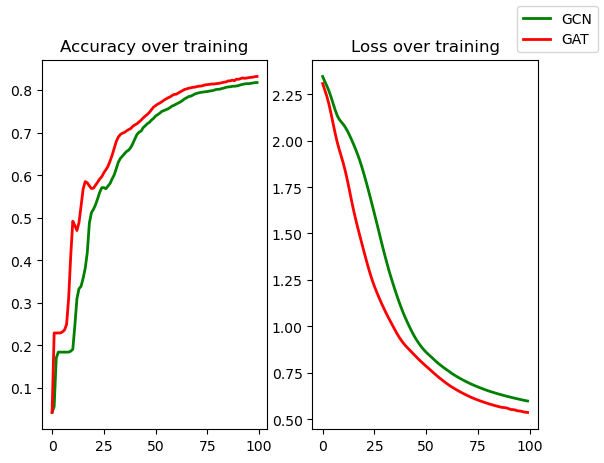

In [12]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(gcn.accuracy, linewidth=2, color='green', label="GCN")
ax[1].plot(gcn.loss, linewidth=2, color='green')

ax[0].plot(gat.accuracy, linewidth=2, color='red', label="GAT")
ax[1].plot(gat.loss, linewidth=2, color='red')

ax[0].set_title('Accuracy over training')
ax[1].set_title('Loss over training')

fig.legend()
fig.show()

In [8]:
labels = ['Computational Linguistics',          # 0
        'Databases',                            # 1
        'Operating Systems',                    # 2
        'Computer Architecture',                # 3
        'Computer Security',                    # 4
        'Internet Protocols',                   # 5
        "Computer File Systems",                # 6
        'Distributed Computing Architecture',   # 7 
        'Web Technology',                       # 8
        "Programming Language"]                 # 9

In [9]:
data.edge_index

tensor([[    0,     0,     0,  ..., 11700, 11700, 11700],
        [ 3925,  5830,  7248,  ...,  7586,  8454, 11306]])

In [13]:
data.x[0]

tensor([-2.0350e-02,  6.4643e-02,  1.9732e-02,  7.4099e-03, -3.8602e-02,
         2.3387e-02,  1.0587e-01, -1.4798e-01,  1.0098e-01,  1.2045e+00,
        -2.2493e-01, -7.7824e-02,  9.5312e-02, -1.6710e-03, -1.1199e-01,
         9.2062e-02,  1.3881e-03,  8.9788e-01,  4.3789e-02, -3.2938e-02,
         4.4461e-02,  1.4274e-01, -2.3118e-02,  9.8274e-03,  5.4011e-02,
         3.2255e-02, -5.8979e-02,  2.5383e-02,  2.7275e-02,  4.3233e-02,
         1.0568e-01, -1.8941e-01,  3.0730e-02,  2.4309e-02, -1.0859e-01,
         2.9326e-02, -8.1450e-02, -9.3722e-02, -2.6157e-02, -2.2192e-02,
         6.2961e-02,  4.4854e-02,  1.7270e-01, -4.4667e-02, -1.1727e-01,
         7.8514e-02,  2.7254e-02, -5.9800e-02, -1.9231e-02, -1.0056e-02,
         7.4689e-03, -4.2051e-02, -9.2576e-02, -1.1339e-01,  8.0031e-03,
        -4.4761e-02, -3.3492e-02, -3.4454e-02,  5.2315e-02, -9.1848e-03,
        -2.2869e-02, -4.2657e-03,  1.6825e-02,  4.5552e-02,  2.2780e-01,
        -2.9103e-02,  3.6836e-02,  5.8039e-02, -7.6

In [10]:
output = gcn(data.x, data.edge_index)

print(labels[data.y[0]])
print(labels[torch.argmax(output[0]).item()])

Distributed Computing Architecture
Distributed Computing Architecture
